Dataset shape: (48120, 4)
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
Missing values in each column:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Model: Linear Regression
Mean Squared Error: 171.19154373772628
Mean Absolute Error: 9.805754511870983
R^2 Score: 0.5799462361472772

Model: Deci

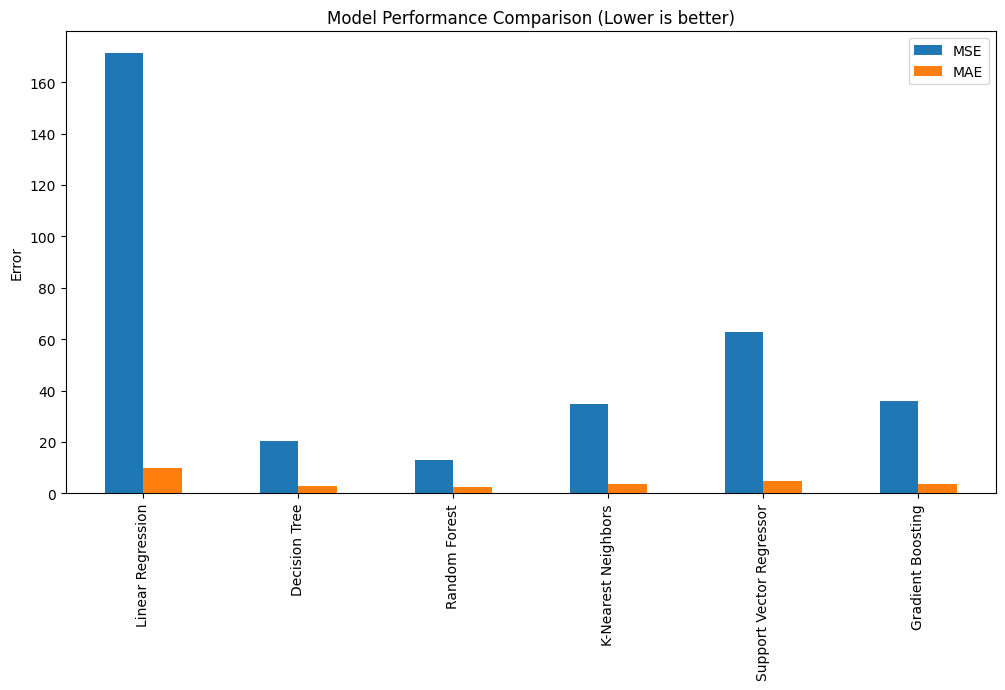


Best parameters found for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 30}
Best MSE score: 17.480840075739774

Final Model Performance:
Mean Squared Error: 13.276806838506989
Mean Absolute Error: 2.3760794704640795
R^2 Score: 0.9674226158448304


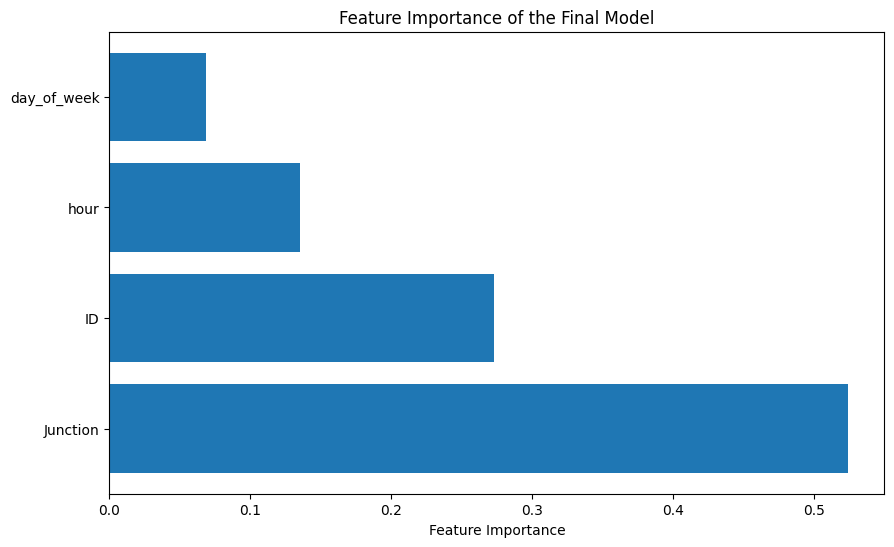

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/traffic.csv')  # Replace with your dataset

# Inspect dataset
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())

# Check for missing data
missing_data = df.isnull().sum()
print("Missing values in each column:\n", missing_data)

# Basic data cleaning (e.g., fill or drop missing values)
df = df.dropna()  # Drop rows with missing data, you can also fill them if necessary

# Convert datetime column if applicable
# Assuming 'date_time' is a column in the dataset
df['DateTime'] = pd.to_datetime(df['DateTime'])  # Replace with the correct column name
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek

# Define feature and target variable
# Replace 'traffic_volume' with the actual target variable name
X = df.drop(['Vehicles', 'DateTime'], axis=1)  # Drop target variable and any unneeded columns
y = df['Vehicles']

# Encode categorical variables if any
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define regressors to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R^2 Score': r2}
    print(f"\nModel: {name}")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

# Display model comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n", results_df)

# Plot results
results_df[['MSE', 'MAE']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison (Lower is better)')
plt.ylabel('Error')
plt.show()

# Hyperparameter tuning example (Random Forest)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42)
random_search.fit(X_train, y_train)

print("\nBest parameters found for Random Forest:", random_search.best_params_)
print("Best MSE score:", -random_search.best_score_)

# Final model evaluation
final_model = random_search.best_estimator_
y_final_pred = final_model.predict(X_test)

# Calculate final metrics
final_mse = mean_squared_error(y_test, y_final_pred)
final_mae = mean_absolute_error(y_test, y_final_pred)
final_r2 = r2_score(y_test, y_final_pred)

print("\nFinal Model Performance:")
print("Mean Squared Error:", final_mse)
print("Mean Absolute Error:", final_mae)
print("R^2 Score:", final_r2)

# Feature Importance (for Random Forest or Gradient Boosting models)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], align='center')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance of the Final Model")
    plt.show()
